In [1]:
import numpy as np
import os
import re
import matplotlib.pyplot as plt
import glob
import pandas as pd
from IPython.display import display
from collections import Counter

# Log reader for day 1
## log gives 1k itterations, previous days data has 10k itterations so scaled by 10
## all outputs from log should be on same line (i.e. every line starts with a time stamp)

In [2]:
#importing data from txt
#all outputs from log should be on same line (i.e. every line starts with a time stamp)
dirc = os.getcwd()
data = pd.DataFrame()
filenames = glob.glob(dirc+'/*.txt')
product = []
positions = []
mm_order = []
size = []
timestamp = []
price = []
spread = []
for file in filenames:
    f = open(file,"r")
    for line in f:
        #removes first few lines on text
        if re.search(r'(^\d*0)', line) == None:
            #print(line)
            continue
        try:
            timestamp.append(int(re.search(r'(^\d*0)', line).group(1)))
        except:
            print('failed')
            
        if 'position: ' in line:
            product.append(str(re.search(r'(PEARLS|BANANA)', line).group(1)))
            positions.append(int(re.search(r'position: (-?\d*)', line).group(1)))
            if 'MM' in line:
                mm_order.append('MM')
                size.append(str(re.findall(r'(\d*.?\d*)x', line)[0])+'/-'+str(re.findall(r'(\d*.?\d*)x', line)[1]))
                price.append(str(re.findall(r'x (\d*)', line)[0])+'/'+str(re.findall(r'x (\d*)', line)[1]))
                spread.append(int(re.search(r'Spread:  *(\d*)', line).group(1)))
            elif 'MISSED' in line:
                mm_order.append('MISSED')
                spread.append(0)
                size.append(float(re.search(r'(\d*.?\d*)x', line).group(1)))
                price.append(float(re.search(r'x (\d*)', line).group(1)))
            else:
                spread.append(0)
                mm_order.append(re.search(r'(SELL|BUY)', line).group(1))
                if re.search(r'(SELL|BUY)', line).group(1) == 'SELL':
                    size.append(-float(re.search(r'(\d*.?\d*)x', line).group(1)))
                else:
                    size.append(float(re.search(r'(\d*.?\d*)x', line).group(1)))
                price.append(float(re.search(r'x (\d*)', line).group(1)))
        else:
            #no trades occured
            product.append(np.nan)
            positions.append(np.nan)
            mm_order.append(np.nan)
            size.append(np.nan)
            price.append(np.nan)
            spread.append(np.nan)

data['timestamp'] = timestamp
data['Product'] = product
data['Position'] = positions
data['MM/order'] = mm_order
data['Size_available'] = size
data['Price'] = price
data['Spread'] = spread
data2 = data.dropna()

display(data2)
#print(data2)
#print(data.describe())

#when are no trades
maskna = ((np.isnan(data['Position']) == True))
data_notrades = data.loc[maskna, :]
display(data_notrades)

,timestamp,Product,Position,MM/order,Size_available,Price,Spread
1,100,PEARLS,-1.0,SELL,-1.0,10002.0,0.0
2,200,PEARLS,-1.0,MM,5.0/-4.0,9997/10003,8.0
3,300,PEARLS,-2.0,MM,5.0/-4.0,9996/10004,10.0
4,400,PEARLS,-2.0,MM,5.0/-4.0,9999/10003,6.0
5,500,PEARLS,-2.0,MM,5.0/-4.0,9999/10003,6.0
...,...,...,...,...,...,...,...
995,99500,PEARLS,0.0,BUY,3.0,9998.0,0.0
996,99600,PEARLS,0.0,MM,5.0/-5.0,9996/10004,10.0
997,99700,PEARLS,0.0,MM,5.0/-5.0,9996/10004,10.0
998,99800,PEARLS,2.0,MM,4.0/-5.0,9997/10001,6.0


,timestamp,Product,Position,MM/order,Size_available,Price,Spread
0,0,NaN,NaN,NaN,NaN,NaN,NaN
8,800,NaN,NaN,NaN,NaN,NaN,NaN
14,1400,NaN,NaN,NaN,NaN,NaN,NaN
18,1800,NaN,NaN,NaN,NaN,NaN,NaN
41,4100,NaN,NaN,NaN,NaN,NaN,NaN
52,5200,NaN,NaN,NaN,NaN,NaN,NaN
68,6800,NaN,NaN,NaN,NaN,NaN,NaN
80,8000,NaN,NaN,NaN,NaN,NaN,NaN
97,9700,NaN,NaN,NaN,NaN,NaN,NaN
109,10900,NaN,NaN,NaN,NaN,NaN,NaN


# MM analysis

In [44]:
#algo never MM adn trades at same time
#display(data2)
data2['Pos_T-1'] = data2['Position'].shift()
data2['Pos_T-1'][1] = 0
data2['Change'] = data2['Position'] - data2['Pos_T-1']
## did MM trade?


#print(data2.columns)
mm = []
for i, *row in data2.itertuples():
    #(data2['MM/order'] == 'MM') and (data2['Change'] != 0)
    m = data2.columns.get_loc('MM/order')
    c = data2.columns.get_loc('Change')
    if row[m] == 'MM' and row[c] != 0:
        mm.append(True)
    else:
        mm.append(False)

data2['MMtrade?'] = mm
display(data2)

C:\Users\tommy\AppData\Local\Temp\ipykernel_18176\362510794.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data2['Pos_T-1'] = data2['Position'].shift()
C:\Users\tommy\AppData\Local\Temp\ipykernel_18176\362510794.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data2['Pos_T-1'][1] = 0
C:\Users\tommy\AppData\Local\Temp\ipykernel_18176\362510794.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.o

,timestamp,Product,Position,MM/order,Size_available,Price,Spread,Pos_T-1,Change,MMtrade?
1,100,PEARLS,-1.0,SELL,-1.0,10002.0,0.0,0.0,-1.0,False
2,200,PEARLS,-1.0,MM,5.0/-4.0,9997/10003,8.0,-1.0,0.0,False
3,300,PEARLS,-2.0,MM,5.0/-4.0,9996/10004,10.0,-1.0,-1.0,True
4,400,PEARLS,-2.0,MM,5.0/-4.0,9999/10003,6.0,-2.0,0.0,False
5,500,PEARLS,-2.0,MM,5.0/-4.0,9999/10003,6.0,-2.0,0.0,False
...,...,...,...,...,...,...,...,...,...,...
995,99500,PEARLS,0.0,BUY,3.0,9998.0,0.0,-3.0,3.0,False
996,99600,PEARLS,0.0,MM,5.0/-5.0,9996/10004,10.0,0.0,0.0,False
997,99700,PEARLS,0.0,MM,5.0/-5.0,9996/10004,10.0,0.0,0.0,False
998,99800,PEARLS,2.0,MM,4.0/-5.0,9997/10001,6.0,0.0,2.0,True


In [43]:
#print(data2['MM/order'].describe())
mm_orders = data2[data2['MM/order'] == 'MM']['MM/order'].count()
#print(data2['MMtrade?'].describe())
hits = data2[data2['MMtrade?'] == True]['MMtrade?'].count()
hit_rate = hits/mm_orders *100
print(hits, ' MM hits out of ', mm_orders, ' orders sent')
print('Hit rate was {:.03f} %'.format(hit_rate))

57  MM hits out of  764  orders sent
Hit rate was 7.461 %


In [46]:
#MM hit data
mask2 = (data2['MMtrade?'] == True)
data_mmhits = data2.loc[mask2, :]
#print(data_mmhits.describe())
#display(data_mmhits)
## note spread is the spread before our MM

###adds market maker bid and ask column
#print(data_mmhits.columns)
#print(data_mmhits.columns.get_loc('Change'))
mmbid = []
mmask = []
for bid, ask in data_mmhits['Price'].str.split('/'):
    mmbid.append(int(bid))
    mmask.append(int(ask))

data_mmhits['MM_Bid'] = mmbid
data_mmhits['MM_Ask'] = mmask

#adds theo profit of individual trades column
fv = 10000
theo = []
for i, *row in data_mmhits.itertuples():
    c = data_mmhits.columns.get_loc('Change')
    b = data_mmhits.columns.get_loc('MM_Bid')
    a = data_mmhits.columns.get_loc('MM_Ask')
    if row[c] > 0:
        #bought on mmbid
        theo.append(row[c]*(fv-row[b]))
    elif row[c] < 0:
        #sold on mmask
        theo.append(-row[c]*(row[a]-fv))
    else:
        #no trade
        theo.append(0)
        
data_mmhits['Theo'] = theo

#min and max of ask and bid should be at min +-1 of FV
# print(data_mmhits.describe())
# display(data_mmhits)
print(f'Theoretical MM PnL: {sum(theo)}')        
##might be useful to calculate a hit rate at each spread, woudl require more testing 
#then can maximise for profit (half) spread*hitrate

Theoretical MM PnL: 431.0


C:\Users\tommy\AppData\Local\Temp\ipykernel_18176\1704134492.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_mmhits['MM_Bid'] = mmbid
C:\Users\tommy\AppData\Local\Temp\ipykernel_18176\1704134492.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_mmhits['MM_Ask'] = mmask
C:\Users\tommy\AppData\Local\Temp\ipykernel_18176\1704134492.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the

In [65]:
display(data2)
data_mmpnl = data2.copy()
cash = []
curr = 0

for i, *row in data_mmpnl.itertuples():
    m = data_mmpnl.columns.get_loc('MM/order')
    c = data_mmpnl.columns.get_loc('Change')
    p = data_mmpnl.columns.get_loc('Price')
    if row[m] == 'MM':
        b = float(row[p].split('/')[0])
        a = float(row[p].split('/')[1])
        if row[c] > 0:
            #bought on mmbid
            curr -= row[c]*b
        elif row[c] < 0:
            #sold on mmask
            curr -= row[c]*a    
        else:
            None
            #no trade
    elif row[m] == 'SELL':
        #cahnge is -ve so curr -= so increases
        curr -= row[c]*row[p]
        
    elif row[m] == 'BUY':
        #cahnge is +ve so curr -= so decreases
        curr -= row[c]*row[p]
    else:
        None
    cash.append(curr)
    
data_mmpnl['Cash'] = cash

pnl = []
#can change to mid value if data collected and input into the dataframe
#use same row index method
fv = 10000
for i, *row in data_mmpnl.itertuples():
    c = data_mmpnl.columns.get_loc('Cash')
    p = data_mmpnl.columns.get_loc('Position')
    pnl.append(row[c]+row[p]*fv)

data_mmpnl['PnL'] = pnl

display(data_mmpnl)

,timestamp,Product,Position,MM/order,Size_available,Price,Spread,Pos_T-1,Change,MMtrade?
1,100,PEARLS,-1.0,SELL,-1.0,10002.0,0.0,0.0,-1.0,False
2,200,PEARLS,-1.0,MM,5.0/-4.0,9997/10003,8.0,-1.0,0.0,False
3,300,PEARLS,-2.0,MM,5.0/-4.0,9996/10004,10.0,-1.0,-1.0,True
4,400,PEARLS,-2.0,MM,5.0/-4.0,9999/10003,6.0,-2.0,0.0,False
5,500,PEARLS,-2.0,MM,5.0/-4.0,9999/10003,6.0,-2.0,0.0,False
...,...,...,...,...,...,...,...,...,...,...
995,99500,PEARLS,0.0,BUY,3.0,9998.0,0.0,-3.0,3.0,False
996,99600,PEARLS,0.0,MM,5.0/-5.0,9996/10004,10.0,0.0,0.0,False
997,99700,PEARLS,0.0,MM,5.0/-5.0,9996/10004,10.0,0.0,0.0,False
998,99800,PEARLS,2.0,MM,4.0/-5.0,9997/10001,6.0,0.0,2.0,True


,timestamp,Product,Position,MM/order,Size_available,Price,Spread,Pos_T-1,Change,MMtrade?,Cash,PnL
1,100,PEARLS,-1.0,SELL,-1.0,10002.0,0.0,0.0,-1.0,False,10002.0,2.0
2,200,PEARLS,-1.0,MM,5.0/-4.0,9997/10003,8.0,-1.0,0.0,False,10002.0,2.0
3,300,PEARLS,-2.0,MM,5.0/-4.0,9996/10004,10.0,-1.0,-1.0,True,20006.0,6.0
4,400,PEARLS,-2.0,MM,5.0/-4.0,9999/10003,6.0,-2.0,0.0,False,20006.0,6.0
5,500,PEARLS,-2.0,MM,5.0/-4.0,9999/10003,6.0,-2.0,0.0,False,20006.0,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...
995,99500,PEARLS,0.0,BUY,3.0,9998.0,0.0,-3.0,3.0,False,1285.0,1285.0
996,99600,PEARLS,0.0,MM,5.0/-5.0,9996/10004,10.0,0.0,0.0,False,1285.0,1285.0
997,99700,PEARLS,0.0,MM,5.0/-5.0,9996/10004,10.0,0.0,0.0,False,1285.0,1285.0
998,99800,PEARLS,2.0,MM,4.0/-5.0,9997/10001,6.0,0.0,2.0,True,-18709.0,1291.0


In [11]:
#noramla orders data
mask1 = ((data2['MMtrade?'] == False) &  (data2['MM/order'] != 'MM'))
data_orders = data2.loc[mask1, :]


#adds theo profit of individual trades column
fv = 10000
theo = []
for i, *row in data_orders.itertuples():
    c = data_orders.columns.get_loc('Change')
    p = data_orders.columns.get_loc('Price')
    if row[c] > 0:
        #bought
        theo.append(row[c]*(fv-row[p]))
    elif row[c] < 0:
        #sold
        theo.append(-row[c]*(row[p]-fv))
    else:
        #no trade
        theo.append(0)
        
data_orders['Theo'] = theo

print(data_orders.describe())
display(data_orders)
print(f'Theoretical market orders PnL: {sum(theo)}')    

          timestamp    Position  Spread     Pos_T-1      Change        Theo
count    176.000000  176.000000   176.0  176.000000  176.000000  176.000000
mean   48340.909091    2.823864     0.0    2.517045    0.306818    4.886364
std    29396.705885   11.644628     0.0   11.462722    3.604308    5.322581
min      100.000000  -20.000000     0.0  -20.000000  -14.000000   -8.000000
25%    20375.000000   -6.250000     0.0   -6.250000   -1.000000    2.000000
50%    46800.000000    5.000000     0.0    5.000000   -0.500000    2.000000
75%    71875.000000   12.000000     0.0   12.000000    1.000000    6.000000
max    99500.000000   20.000000     0.0   20.000000   12.000000   28.000000


C:\Users\tommy\AppData\Local\Temp\ipykernel_18176\147979920.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_orders['Theo'] = theo


,timestamp,Product,Position,MM/order,Size_available,Price,Spread,Pos_T-1,Change,MMtrade?,Theo
1,100,PEARLS,-1.0,SELL,-1.0,10002.0,0.0,0.0,-1.0,False,2.0
9,900,PEARLS,9.0,BUY,11.0,9998.0,0.0,-2.0,11.0,False,22.0
13,1300,PEARLS,8.0,SELL,-1.0,10002.0,0.0,9.0,-1.0,False,2.0
15,1500,PEARLS,12.0,BUY,4.0,9998.0,0.0,8.0,4.0,False,8.0
22,2200,PEARLS,16.0,BUY,4.0,9998.0,0.0,12.0,4.0,False,8.0
...,...,...,...,...,...,...,...,...,...,...,...
979,97900,PEARLS,7.0,SELL,-3.0,10002.0,0.0,10.0,-3.0,False,6.0
983,98300,PEARLS,3.0,BUY,1.0,9998.0,0.0,2.0,1.0,False,2.0
985,98500,PEARLS,4.0,BUY,1.0,9998.0,0.0,3.0,1.0,False,2.0
993,99300,PEARLS,-3.0,BUY,1.0,9998.0,0.0,-6.0,3.0,False,6.0


Theoretical market orders PnL: 860.0


# Plots to determine strategy areas of improvement 

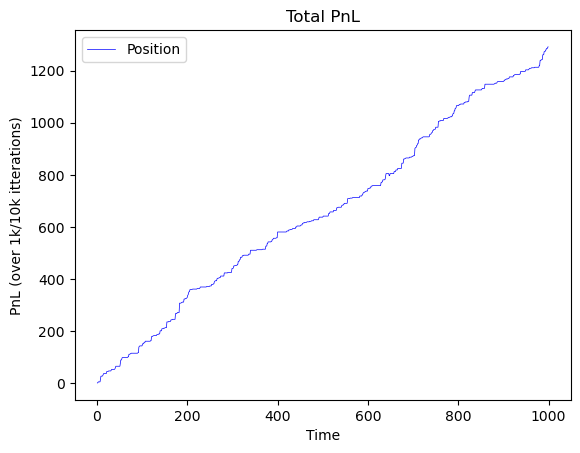

In [74]:
#PnL plot

#plot 1 pnl x time
pnl = data_mmpnl['PnL']
t = data_mmpnl['timestamp']

plt.plot(pnl , label = 'Position', linewidth = 0.5, color = 'Blue')

#activate to see where mm trades
# mm_trade = data_mmpnl.loc[data_mmpnl['MMtrade?'] == True]['PnL']
# plt.plot(mm_trade, 'r+', label = 'MM trade')        
        
plt.xlabel('Time')
plt.ylabel('PnL (over 1k/10k itterations)')
plt.legend()
plt.title("Total PnL")
plt.show()

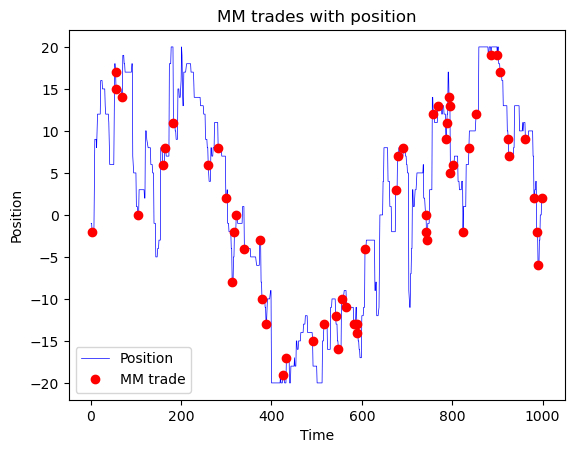

In [6]:
#useful to plot data with dots when we make a trade (mm or order) diff colour

#plot 2 pos x mm
pos = data2['Position']
t = data2['timestamp']

plt.plot(pos , label = 'Position', linewidth = 0.5, color = 'Blue')

# #plots dots
# for i, *row in data2.itertuples():
#     #check for MM trade 
#     if row[8]:
#         #print(row, row[21])
#         plt.plot(i,row[1], 'ro')
plt.plot(data_mmhits['Position'], 'ro', label = 'MM trade')        
        
plt.xlabel('Time')
plt.ylabel('Position')
plt.legend()
plt.title("MM trades with position")
plt.show()


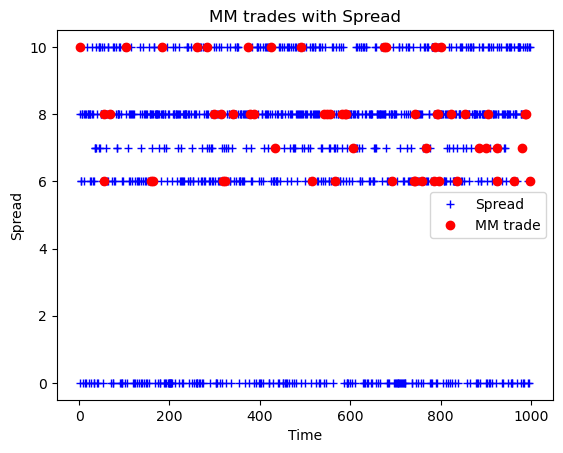

In [7]:
#plot 3 spread x mm
plt.plot(data2['Spread'], 'b+', label = 'Spread')
plt.plot(data_mmhits['Spread'], 'ro', label = 'MM trade')    
plt.xlabel('Time')
plt.ylabel('Spread')
plt.legend()
plt.title("MM trades with Spread")
plt.show()

0.0 0.0
8.0 0.06521739130434782
10.0 0.06741573033707865
6.0 0.09444444444444444
7.0 0.08333333333333333


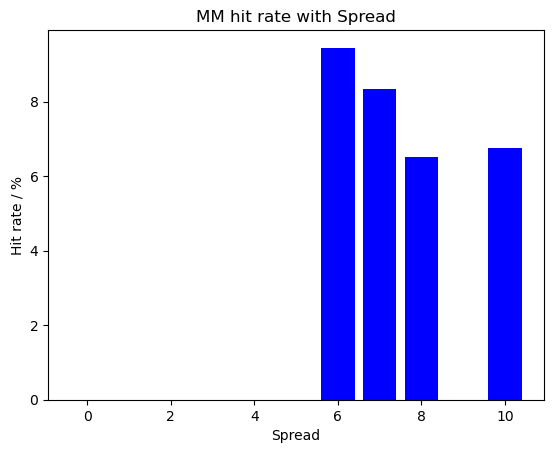

In [8]:
#plot 4 spread hit rate
spread_orders = Counter(data2['Spread'])
spread_hits = Counter(data_mmhits['Spread'])
spread_hitrate = {}
for key in spread_orders.keys():
    spread_hitrate[key] = spread_hits[key]/spread_orders[key]
#print(spread_hitrate)

for k,r in spread_hitrate.items():
    print(k,r)
    plt.bar(k,r*100,color='blue')
    
plt.xlabel('Spread')
plt.ylabel('Hit rate / %')
plt.title("MM hit rate with Spread")
plt.show()

Counter({8.0: 21, 6.0: 17, 10.0: 12, 7.0: 7})
0.0 nan
8.0 8.285714285714286
10.0 11.0
6.0 4.764705882352941
7.0 6.285714285714286


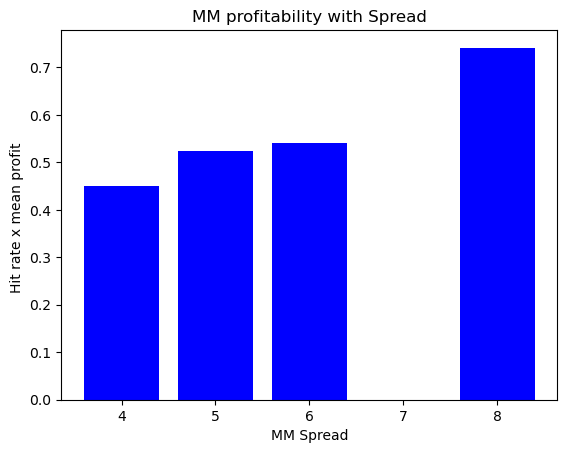

In [31]:
#plot 5 profitability does not include volume or theo yet
#display(data_mmhits)
spread_orders = Counter(data2['Spread'])
spread_hits = Counter(data_mmhits['Spread'])
# print(spread_orders)
print(spread_hits)
# print(spread_hitrate)

spread_profitability = {}
for key in spread_orders.keys():
    av_theo = np.mean(data_mmhits.loc[data_mmhits['Spread'] == key, :]['Theo'])
    print(key, av_theo)
    spread_profitability[key] = (spread_hits[key]/spread_orders[key])*av_theo

for k,r in spread_profitability.items():
    #print(k,r)
    plt.bar(k-2,r,color='blue')
    
plt.xlabel('MM Spread')
plt.ylabel('Hit rate x mean profit ')
plt.title("MM profitability with Spread")
plt.show()

# 0 0.0
# 8 0.06521739130434782
# 10 0.06741573033707865
# 6 0.09444444444444444
# 7 0.08333333333333333